# Bachelor Notebook

## Import Statements

contains the import statements for all necessary packages

In [2]:
from os import listdir
from os.path import isfile, join
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from fastai.data.all import *
from fastai.vision.all import *
#from fastai.vision.image import *
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
import shutil
from PIL import Image
from matplotlib.pyplot import imshow
import torch
from torch.overrides import *
from torch.nn.functional import *
from torch.nn.modules.loss import _WeightedLoss
from torch.nn import *
#from IPython.core.debugg

## Define paths
define the paths to the relevant data

In [2]:
data_path=r"D:\Bachelor\data"
image_path=data_path+r"\ImageFiles"
image_path_reduced=data_path+r"\ImageFiles_reduced"
ship_image_path=image_path+r"\ships"
ship_image_path_reduced=image_path_reduced+r"\ships"
ship_csv_path=data_path+r"shipsAIS_2017_Zone17.csv"
nonship_image_path=image_path+r"\non_ships"
nonship_image_path_reduced=image_path_reduced+r"\non_ships"
nonship_csv_path=data_path+r"\nonshipsAIS_2017_Zone17.csv"

## Search for misplaced directories
Some image directories are misplaced, instead of being located in ships or nonships, certain subdirectories are located in other subdirectories. The following method finds the affected subdirectories and prints them.

In [ ]:
def get_misplaced_directories(path):
    misplaced_directories=[]
    for d in listdir(path):
        if os.path.isdir(join(path,d)):
            for f in listdir(join(path,d)):
                if os.path.isdir(join(join(path,d),f)):
                    misplaced_directories.append(join(path,d))
    return misplaced_directories

In [ ]:
get_misplaced_directories(ship_image_path)

In [ ]:
get_misplaced_directories(nonship_image_path)

## Correct misplaced directories
The following two methods correct the location of the aforementioned misplaced subdirectories.

In [ ]:
def correct_misplaced_directories(path):
    misplaced_directories=[]
    main_dir=listdir(path)
    for d in main_dir:
        sub_dir=join(path,d)
        if os.path.isdir(sub_dir):
            for f in listdir(sub_dir):
                current_path=join(sub_dir,f)
                if os.path.isdir(current_path):
                    #misplaced_directories.append(current_directory)
                    correct_misplaced_directories_r(path,current_path)
                    #correct dir
                    if f in main_dir:
                        shutil.rmtree(current_path)
                    else:
                        shutil.move(current_path,path)

def correct_misplaced_directories_r(main_path,path):
    main_dir=listdir(main_path)
    for d in listdir(path):
        current_path=join(path,d)
        if os.path.isdir(current_path):
            correct_misplaced_directories_r(main_path,current_path)
            #correct dir
            if d in main_dir:
                shutil.rmtree(current_path)
            else:
                shutil.move(current_path,main_path)
        

In [ ]:
correct_misplaced_directories(ship_image_path)
correct_misplaced_directories(nonship_image_path)

## Test

In [ ]:
nonship_image_files = []# [f for f in dir1 for dir1 in listdir(nonship_image_path) if isfile(join(nonship_image_path,join(dir, f))) and ".tif" in f]
for directory in listdir(nonship_image_path):
    nonship_image_files+=[join(join(nonship_image_path,directory),f) for f in os.listdir(join(nonship_image_path,directory)) if ".tif" in f and "udm" not in f]
#ship_image_files = [f for f in listdir(ship_image_path) if isfile(join(ship_image_path, f))]
#ship_image_files = []# [f for f in dir1 for dir1 in listdir(nonship_image_path) if isfile(join(nonship_image_path,join(dir, f))) and ".tif" in f]
ship_image_files=[]
for directory in listdir(ship_image_path):
    ship_image_files+=[join(join(ship_image_path,directory),f) for f in os.listdir(join(ship_image_path,directory)) if ".tif" in f and "udm" not in f]
nonship_images=[rasterio.open(f) for f in nonship_image_files]
ship_images=[rasterio.open(f) for f in ship_image_files] 

In [ ]:
%matplotlib notebook
sim=ship_images[0]
arr=sim.read()
arr=np.swapaxes(arr,0,2)
#print(arr.shape)
arr=arr[:,:,:3]
m=arr.max()
#print(arr.min())
arr=arr/(m+1)*255
imshow(arr.astype(np.uint8))#,norm=matplotlib.colors.Normalize(0,32000))
#print(arr.astype(np.uint8).max())
#print(arr.astype(np.uint8).min())

## Test ImageReading

In [ ]:
sim=ship_images[0]
arr=sim.read()
arr=np.swapaxes(arr,0,2)
#print(arr.shape)
arr=arr[:,:,:3]
m=arr.max()
#print(arr.min())
arr=arr/(m+1)*255
img=Image.fromarray(arr.astype(np.uint8),"RGB")
img.show()

## Getter functions
definition of get_items and get_y for DataBlocks

In [3]:
def get_4ch_tif_files(path):
    file_paths=[]
    for root,directories,files in os.walk(path):
        #print(root)
        file_paths+=[Path(join(root,f)) for f in files if ".tif" in f and "udm" not in f]
    return L(file_paths)

def get_data_y(item):
    return Path(item).parent.parent.name

In [ ]:
type(get_image_files(ship_image_path))
#type(get_image_files(ship_image_path)[0])

In [ ]:
type(get_4ch_tif_files(ship_image_path))

## Modified TensorImage

In [4]:
class TensorImage4Ch(TensorImage):
    def show(self, ctx=None, **kwargs):
        rgbTensor=self[:3,:,:]
        return show_image(rgbTensor, ctx=ctx, **{**self._show_args, **kwargs})
        

## Transform functions
transformation functions for the independent variable

In [5]:
width=-1
height=-1


def get_image(item):
    img=rasterio.open(item)
    b,g,r,n=img.read()
    channels=tuple([r,g,b,n])
    arr=np.dstack(channels)
    arr=(arr/32000)
    arr=(arr).astype(np.float32)
    t=TensorImage4Ch(image2tensor(torch.Tensor(arr)))
    t=t.type(torch.float32)
    #print(t.shape)
    return t#[:3,:,:]

class crop_middle(Transform):
    def __init__(self, size=400, randomnes=25):
        self.size = size
        self.randomnes = randomnes
    def encodes(self, x:TensorImage):
        data=x
        rows = data.shape[1]
        cols = data.shape[2]
        mid_row = int(rows/2)
        mid_col = int(cols/2)
        start_row = mid_row - int(self.size/2)
        start_col = mid_col - int(self.size/2)
        col_dist, row_dist = np.random.randint(low=-self.randomnes, high=self.randomnes, size=2)
        start_row += row_dist
        start_col += col_dist
        data = data[:,start_row : start_row+self.size, start_col: start_col+self.size]
        return data

## One Hot Encoded Category

In [ ]:
#copied from https://github.com/fastai/fastai/blob/f633356359a29f8d869ce36659f7aa25660e946a/fastai/data/transforms.py#L230
class Categorize_OneHot(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, sort=True, add_na=False):
        if vocab is not None: vocab = CategoryMap(vocab, sort=sort, add_na=add_na)
        store_attr()

    def setups(self, dsets):
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o):
        try:
            #change to one-hot-encoding
            
            length=len(self.vocab.o2i)
            y_vec=torch.zeros(length)
            y_vec[self.vocab.o2i[o]]=1
            return TensorCategory(y_vec.type(torch.LongTensor))#TensorCategory(self.vocab.o2i[o])
        except KeyError as e:
            raise KeyError(f"Label '{o}' was not included in the training dataset") from e
    #change
    def decodes(self, o): 
        index=torch.argmax(o)
        return Category(self.vocab[index])

## CategoryBlock, output as float

In [ ]:
#copied from https://github.com/fastai/fastai/blob/f633356359a29f8d869ce36659f7aa25660e946a/fastai/data/transforms.py#L230
class Categorize32f(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, sort=True, add_na=False):
        if vocab is not None: vocab = CategoryMap(vocab, sort=sort, add_na=add_na)
        store_attr()

    def setups(self, dsets):
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o):
        try:
            return TensorCategory(self.vocab.o2i[o]).type(torch.float32)
        except KeyError as e:
            raise KeyError(f"Label '{o}' was not included in the training dataset") from e
    def decodes(self, o): return Category      (self.vocab    [o.type(torch.int32)])

## Load Data
definition of the DataBlock

In [ ]:
Resize??

In [ ]:
images=DataBlock(
    blocks=(TransformBlock([get_image]),CategoryBlock),
    #TransformBlock(type_tfms=Categorize_OneHot(vocab=None, sort=True, add_na=False))),
    #TransformBlock(type_tfms=Categorize32f(vocab=None, sort=True, add_na=False))),
    get_items=get_4ch_tif_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=get_data_y,
    item_tfms=crop_middle(size=300),
    batch_tfms=aug_transforms())

In [ ]:
dls=images.dataloaders(image_path,num_workers=0,bs=32)
dls.valid.show_batch(max_n=8, nrows=1)


In [6]:
images_reduced=DataBlock(
    blocks=(TransformBlock([get_image]),CategoryBlock),
    #TransformBlock(type_tfms=Categorize_OneHot(vocab=None, sort=True, add_na=False))),
    #TransformBlock(type_tfms=Categorize32f(vocab=None, sort=True, add_na=False))),
    get_items=get_4ch_tif_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=get_data_y,
    item_tfms=crop_middle(size=300))

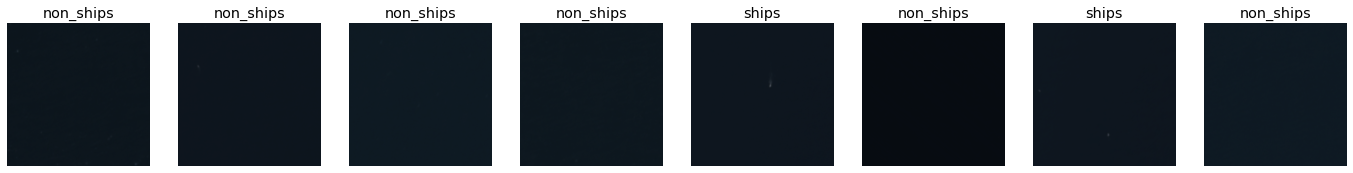

In [7]:
dls_red=images_reduced.dataloaders(image_path_reduced,num_workers=0,bs=12)
dls_red.valid.show_batch(max_n=8, nrows=1)

In [ ]:
dls.valid

In [ ]:
x,y=first(dls_red.valid)

In [ ]:
x

In [ ]:
y

## further tests

In [ ]:
nonship_images[5].shape


In [ ]:
show(ship_images[8].read(4))
np.max(ship_images[8].count)

In [ ]:
ship_images[7]

## Training

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

## Test

In [ ]:
ts=aug_transforms()

In [ ]:
from fastai.vision.models import *

In [ ]:
resnet34??

## Network Test

In [8]:
class Test_Net(nn.Module):
    def __init__(self):
        super(Test_Net,self).__init__()
        self.Conv1=nn.Conv2d(4,50,kernel_size=3,padding=1)
        self.ReLU1=nn.ReLU()
        self.Pool1=nn.MaxPool2d(kernel_size=2)
        self.Conv2=nn.Conv2d(50,24,kernel_size=3,padding=1)
        self.ReLU2=nn.ReLU()
        self.Pool2=nn.MaxPool2d(kernel_size=2)
        self.Conv3=nn.Conv2d(24,4,kernel_size=3,padding=1)
        self.ReLU3=nn.ReLU()
        self.Pool3=nn.MaxPool2d(kernel_size=2)
        #print(type(self.Pool3))
        self.Flat1=Flatten()
        self.Dense1=nn.Linear(5476,100)
        self.ReLU4=nn.ReLU()
        self.Dense2=nn.Linear(100,1)
        self.ReLU5=nn.ReLU()
        #self.Softmax=nn.Softmax(dim=1)
        #self.Flat2=Flatten()
    def forward(self,x):
        #print("forward")
        res=self.Conv1(x)
        res=self.ReLU1(res)
        res=self.Pool1(res)
        res=self.Conv2(res)
        res=self.ReLU2(res)
        res=self.Pool2(res)
        res=self.Conv3(res)
        res=self.ReLU3(res)
        res=self.Pool3(res)
        res=self.Flat1(res)
        res=self.Dense1(res)
        res=self.ReLU4(res)
        res=self.Dense2(res)
        #res=self.Softmax(res)
        #res=self.Flat2(res)
        res=self.ReLU5(res)
        return res

In [ ]:
class Test_Net2(nn.Module):
    def __init__(self):
        super(Test_Net2,self).__init__()
        self.Conv1=nn.Conv2d(4,120,kernel_size=3,padding=1)
        self.ReLU1=nn.ReLU()
        self.Pool1=nn.MaxPool2d(kernel_size=2)
        self.Conv2=nn.Conv2d(120,24,kernel_size=3,padding=1)
        self.ReLU2=nn.ReLU()
        self.Pool2=nn.MaxPool2d(kernel_size=2)
        self.Conv3=nn.Conv2d(24,4,kernel_size=3,padding=1)
        self.ReLU3=nn.ReLU()
        self.Pool3=nn.MaxPool2d(kernel_size=2)
        #print(type(self.Pool3))
        self.Conv4=nn.Conv2d(4,1,kernel_size=3,padding=1)
        self.ReLU4=nn.ReLU()
        self.Pool4=nn.MaxPool2d(kernel_size=2)
        self.Dense1=nn.Linear(5476,100)
        self.ReLU5=nn.ReLU()
        self.Dense2=nn.Linear(100,1)
        self.ReLU6=nn.ReLU()
        #self.Softmax=nn.Softmax(dim=1)
        #self.Flat2=Flatten()
    def forward(self,x):
        print("forward")
        res=self.Conv1(x)
        res=self.ReLU1(res)
        res=self.Pool1(res)
        res=self.Conv2(res)
        res=self.ReLU2(res)
        res=self.Pool2(res)
        res=self.Conv3(res)
        res=self.ReLU3(res)
        res=self.Pool3(res)
        res=self.Conv4(res)
        res=self.ReLU4(res)
        res=self.Pool4(res)
        print(res.shape)
        #res=self.Flat1(res)
        res=self.Dense1(res)
        res=self.ReLU5(res)
        res=self.Dense2(res)
        #res=self.Softmax(res)
        #res=self.Flat2(res)
        res=self.ReLU6(res)
        return res

In [ ]:
first_test=nn.Sequential(nn.Conv2d(4,10,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                         nn.Conv2d(10,8,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                         nn.Conv2d(8,4,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                         Flatten(),
                         nn.Linear(5476,100),nn.ReLU(),
                         nn.Linear(100,1),nn.Softmax(dim=1))

In [ ]:
x=to_cpu(x)
first_test(x).shape

In [ ]:
x=torch.randn(32,1,18,18)
x.shape
l=nn.Linear(5476,100)
x=l(x)

In [9]:
tn=Test_Net()

In [ ]:
x=to_cpu(x)
x=tn(x)
x

In [3]:
accuracy??

In [4]:
flatten_check??

In [10]:
def metric_function(pred,targ):
    cuda0 = torch.device('cuda:0')
    pointfive_tensor=torch.zeros(pred.shape,device=cuda0).float()+0.5
    print(pred)
    print(targ)
    return ((pred>pointfive_tensor)==targ).float().mean()

In [ ]:
def accuracy_mod(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    print(pred)
    return (pred == targ).float().mean()

In [12]:
learn = Learner(dls_red, tn, loss_func=BCELoss_mod(), metrics=metric_function)

In [13]:
learn.fit_one_cycle(10, 0.0001)

epoch,train_loss,valid_loss,metric_function,time
0,1.219111,0.995832,0.538462,00:24
1,1.071572,0.737868,0.538462,00:24
2,0.921255,0.719859,0.461538,00:24
3,0.843561,0.697221,0.461538,00:24
4,0.799305,0.691072,0.538462,00:24
5,0.768563,0.695919,0.461538,00:24
6,0.747875,0.699288,0.461538,00:24
7,0.733216,0.700042,0.461538,00:24
8,0.722837,0.699782,0.461538,00:24
9,0.714840,0.699525,0.461538,00:24


tensor([[0.1391],
        [0.1387],
        [0.1383],
        [0.1388],
        [0.1386],
        [0.1401],
        [0.1386],
        [0.1384],
        [0.1386],
        [0.1360],
        [0.1365],
        [0.1358]], device='cuda:0')
TensorCategory([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0', dtype=torch.int32)
tensor([[0.1371],
        [0.1385],
        [0.1385],
        [0.1379],
        [0.1382],
        [0.1395],
        [0.1395],
        [0.1395],
        [0.1400],
        [0.1373],
        [0.1274],
        [0.1371]], device='cuda:0')
TensorCategory([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
tensor([[0.1388],
        [0.1391],
        [0.1385],
        [0.1387],
        [0.1369],
        [0.1355],
        [0.1391],
        [0.1381],
        [0.1364],
        [0.1399],
        [0.1399],
        [0.1382]], device='cuda:0')
TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
tensor([[0.1379],
        [0.13

tensor([[0.5276],
        [0.5287],
        [0.5316],
        [0.5275],
        [0.5310],
        [0.5389],
        [0.5286],
        [0.5299],
        [0.5316],
        [0.5226],
        [0.5249],
        [0.5290]], device='cuda:0')
TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
tensor([[0.5319],
        [0.5346],
        [0.5320]], device='cuda:0')
TensorCategory([0, 0, 1], device='cuda:0', dtype=torch.int32)
tensor([[0.5277],
        [0.5265],
        [0.5307],
        [0.5291],
        [0.5273],
        [0.5230],
        [0.5274],
        [0.5310],
        [0.5325],
        [0.5335],
        [0.5301],
        [0.5328]], device='cuda:0')
TensorCategory([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0', dtype=torch.int32)
tensor([[0.5264],
        [0.5307],
        [0.5274],
        [0.5321],
        [0.5283],
        [0.5250],
        [0.5259],
        [0.5251],
        [0.5225],
        [0.5322],
        [0.5381],
        [0.5338]], dev

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.show_results()

In [ ]:
type(x)

In [ ]:
learn.fine_tune(5)

In [ ]:
lr_min,lr_steep = learn.lr_find()

In [ ]:
learn.fine_tune??

In [ ]:
has_torch_function??

In [ ]:
accuracy??

In [ ]:
from torch.overrides import *

In [ ]:
learn.summary()

In [ ]:
F.cross_entropy(torch.tensor(3),torch.tensor(5))

In [ ]:
def x_entropy(input, target):#, weight, size_average, ignore_index, reduce, reduction):
    print(input)
    print(target)
    F.cross_entropy(input, target.type(torch.long))#, weight, size_average, ignore_index, reduce, reduction)

In [ ]:
F.cross_entropy??

In [ ]:
def x_entropy_v2(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Optional[Tensor], Optional[bool], int, Optional[bool], str) -> Tensor
    target=target.type(torch.long)
    #target=tensor(target)
    #target = torch.empty_like(target).copy_(target)
    #print(input.shape)
    #print(target.shape)
    #print(type(input))
    #print(type(target))
    r"""This criterion combines `log_softmax` and `nll_loss` in a single
    function.

    See :class:`~torch.nn.CrossEntropyLoss` for details.

    Args:
        input (Tensor) : :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
            in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
            in the case of K-dimensional loss.
        target (Tensor) : :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
            or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
            K-dimensional loss.
        weight (Tensor, optional): a manual rescaling weight given to each
            class. If given, has to be a Tensor of size `C`
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
            the losses are averaged over each loss element in the batch. Note that for
            some losses, there multiple elements per sample. If the field :attr:`size_average`
            is set to ``False``, the losses are instead summed for each minibatch. Ignored
            when reduce is ``False``. Default: ``True``
        ignore_index (int, optional): Specifies a target value that is ignored
            and does not contribute to the input gradient. When :attr:`size_average` is
            ``True``, the loss is averaged over non-ignored targets. Default: -100
        reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
            losses are averaged or summed over observations for each minibatch depending
            on :attr:`size_average`. When :attr:`reduce` is ``False``, returns a loss per
            batch element instead and ignores :attr:`size_average`. Default: ``True``
        reduction (string, optional): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`. Default: ``'mean'``

    Examples::

        >>> input = torch.randn(3, 5, requires_grad=True)
        >>> target = torch.randint(5, (3,), dtype=torch.int64)
        >>> loss = F.cross_entropy(input, target)
        >>> loss.backward()
    """
    if not torch.jit.is_scripting():
        tens_ops = (input, target)
        if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
            return handle_torch_function(
                cross_entropy, tens_ops, input, target, weight=weight,
                size_average=size_average, ignore_index=ignore_index, reduce=reduce,
                reduction=reduction)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)
    return nll_loss(log_softmax(input, 1), target, weight, None, ignore_index, None, reduction)

In [ ]:
F.cross_entropy??

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
target=TensorCategory(target)
loss = x_entropy_v2(input, target)
loss.backward()

In [11]:
class BCELoss_mod(_WeightedLoss):
    r"""Creates a criterion that measures the Binary Cross Entropy
    between the target and the output:

    The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:

    .. math::
        \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right],

    where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
    (default ``'mean'``), then

    .. math::
        \ell(x, y) = \begin{cases}
            \operatorname{mean}(L), & \text{if reduction} = \text{'mean';}\\
            \operatorname{sum}(L),  & \text{if reduction} = \text{'sum'.}
        \end{cases}

    This is used for measuring the error of a reconstruction in for example
    an auto-encoder. Note that the targets :math:`y` should be numbers
    between 0 and 1.

    Notice that if :math:`x_n` is either 0 or 1, one of the log terms would be
    mathematically undefined in the above loss equation. PyTorch chooses to set
    :math:`\log (0) = -\infty`, since :math:`\lim_{x\to 0} \log (x) = -\infty`.
    However, an infinite term in the loss equation is not desirable for several reasons.

    For one, if either :math:`y_n = 0` or :math:`(1 - y_n) = 0`, then we would be
    multiplying 0 with infinity. Secondly, if we have an infinite loss value, then
    we would also have an infinite term in our gradient, since
    :math:`\lim_{x\to 0} \frac{d}{dx} \log (x) = \infty`.
    This would make BCELoss's backward method nonlinear with respect to :math:`x_n`,
    and using it for things like linear regression would not be straight-forward.

    Our solution is that BCELoss clamps its log function outputs to be greater than
    or equal to -100. This way, we can always have a finite loss value and a linear
    backward method.


    Args:
        weight (Tensor, optional): a manual rescaling weight given to the loss
            of each batch element. If given, has to be a Tensor of size `nbatch`.
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
            the losses are averaged over each loss element in the batch. Note that for
            some losses, there are multiple elements per sample. If the field :attr:`size_average`
            is set to ``False``, the losses are instead summed for each minibatch. Ignored
            when reduce is ``False``. Default: ``True``
        reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
            losses are averaged or summed over observations for each minibatch depending
            on :attr:`size_average`. When :attr:`reduce` is ``False``, returns a loss per
            batch element instead and ignores :attr:`size_average`. Default: ``True``
        reduction (string, optional): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`. Default: ``'mean'``

    Shape:
        - Input: :math:`(N, *)` where :math:`*` means, any number of additional
          dimensions
        - Target: :math:`(N, *)`, same shape as the input
        - Output: scalar. If :attr:`reduction` is ``'none'``, then :math:`(N, *)`, same
          shape as input.

    Examples::

        >>> m = nn.Sigmoid()
        >>> loss = nn.BCELoss()
        >>> input = torch.randn(3, requires_grad=True)
        >>> target = torch.empty(3).random_(2)
        >>> output = loss(m(input), target)
        >>> output.backward()
    """
    __constants__ = ['reduction']

    def __init__(self, weight: Optional[Tensor] = None, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(BCELoss_mod, self).__init__(weight, size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        #print(input.shape)
        target=target[:,None]
        target=target.type(torch.float)
        #print(target.shape)
        return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [ ]:
from torch.nn.modules.loss import _WeightedLoss
from torch.nn import *

In [ ]:
m = nn.Sigmoid()
loss = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
a=output.backward()
type(a)